In [48]:
import numpy as np
import pandas as pd
import scipy

import hdf5plugin
import h5py

import matplotlib.pyplot as plt
import matplotlib.gridspec 
%matplotlib inline

import warnings

In [49]:
df = pd.read_csv('../test/batches/batch_000.csv')
df

,frequency_index,frequency,kurtosis,snr,width,flags,source file
0,309504,3150.599924,374.900730,8.187326,0.000016,blip,/home/andres/breakthrough-listen/data/blc40_gu...
1,374208,3150.419317,9.239906,1.012633,0.000019,NaN,/home/andres/breakthrough-listen/data/blc40_gu...
2,393184,3150.366210,7.560742,0.559425,0.000006,NaN,/home/andres/breakthrough-listen/data/blc40_gu...
3,399328,3150.349009,3.840029,0.600045,0.000012,NaN,/home/andres/breakthrough-listen/data/blc40_gu...
4,404448,3150.334653,6.864958,0.579001,0.000010,NaN,/home/andres/breakthrough-listen/data/blc40_gu...
...,...,...,...,...,...,...,...
611,63158784,2975.001093,33.579933,2.614786,0.000005,NaN,/home/andres/breakthrough-listen/data/blc40_gu...
612,63158816,2975.001094,32.817574,2.491323,0.000005,NaN,/home/andres/breakthrough-listen/data/blc40_gu...
613,64172224,2972.169619,0.646790,0.334978,0.000006,nan fits: 10,/home/andres/breakthrough-listen/data/blc40_gu...
614,64948736,2969.999998,20.476213,1.211074,0.000006,NaN,/home/andres/breakthrough-listen/data/blc40_gu...


In [50]:
f = h5py.File('/home/andres/breakthrough-listen/data/blc40_guppi_59358_40991_HIP3740_0031.rawspec.0000.h5')
fch1 = f['data'].attrs['fch1']
foff = f['data'].attrs['foff']
tsamp = f['data'].attrs['tsamp']
WINDOW_SIZE = 64


In [60]:
def signal_model(x, mean, stdev, amplitude, noise):
    exponent = -0.5 * ((x - mean) / stdev)**2
    return noise + amplitude * np.exp(exponent)

def fit_gaussian_to_slice(freq_array: np.ndarray, slice_data: np.ndarray):
    return scipy.optimize.curve_fit(
        signal_model, 
        freq_array, 
        slice_data, 
        p0=[
            freq_array[np.argmax(slice_data)], 
            np.abs(foff),
            np.max(slice_data) - np.median(slice_data),
            np.median(slice_data)
        ],
        # slow, screws up scale for some signals
        bounds=np.array([
            (freq_array[-1], freq_array[0]),
            (0, np.inf),
            (np.median(slice_data)*0.25, np.inf),
            (0, np.inf)
        ]).T,
        max_nfev=10_000
    )

def fit_frequency_gaussians(freq_array: np.ndarray, block: np.ndarray):
        """
        Fits a Gaussian to each frequency slice of the block.
        Returns parameters and covariance for each slice, with dimensions (num_slices, 4) and (num_slices, 4, 4).
        Failed fits result in NaN parameters for that slice."""
        all_params = []
        all_covs = []
        for i in range(block.shape[0]):
            slice_data = block[i, :]
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings('error')
                    params, cov = fit_gaussian_to_slice(freq_array, slice_data)
            except (RuntimeError, ValueError, scipy.optimize.OptimizeWarning) as e:
                # print(e)
                # Return NaN parameters for failed fits
                params = np.full((4,), np.nan)
                cov = np.full((4, 4), np.nan)
            all_params.append(params)
            all_covs.append(cov)
        params = np.array(all_params)
        covs = np.array(all_covs)
        return params, covs

def zap_dc(block, l_idx):
    r_idx = l_idx + WINDOW_SIZE
    COARSE_PER_FINE = 2**20

    r_to_spike = (r_idx + COARSE_PER_FINE//2) % COARSE_PER_FINE
    if r_to_spike > WINDOW_SIZE: return

    spike_idx = WINDOW_SIZE - r_to_spike
    block[:, spike_idx] = (block[:, spike_idx-1] + block[:, spike_idx+1])/2

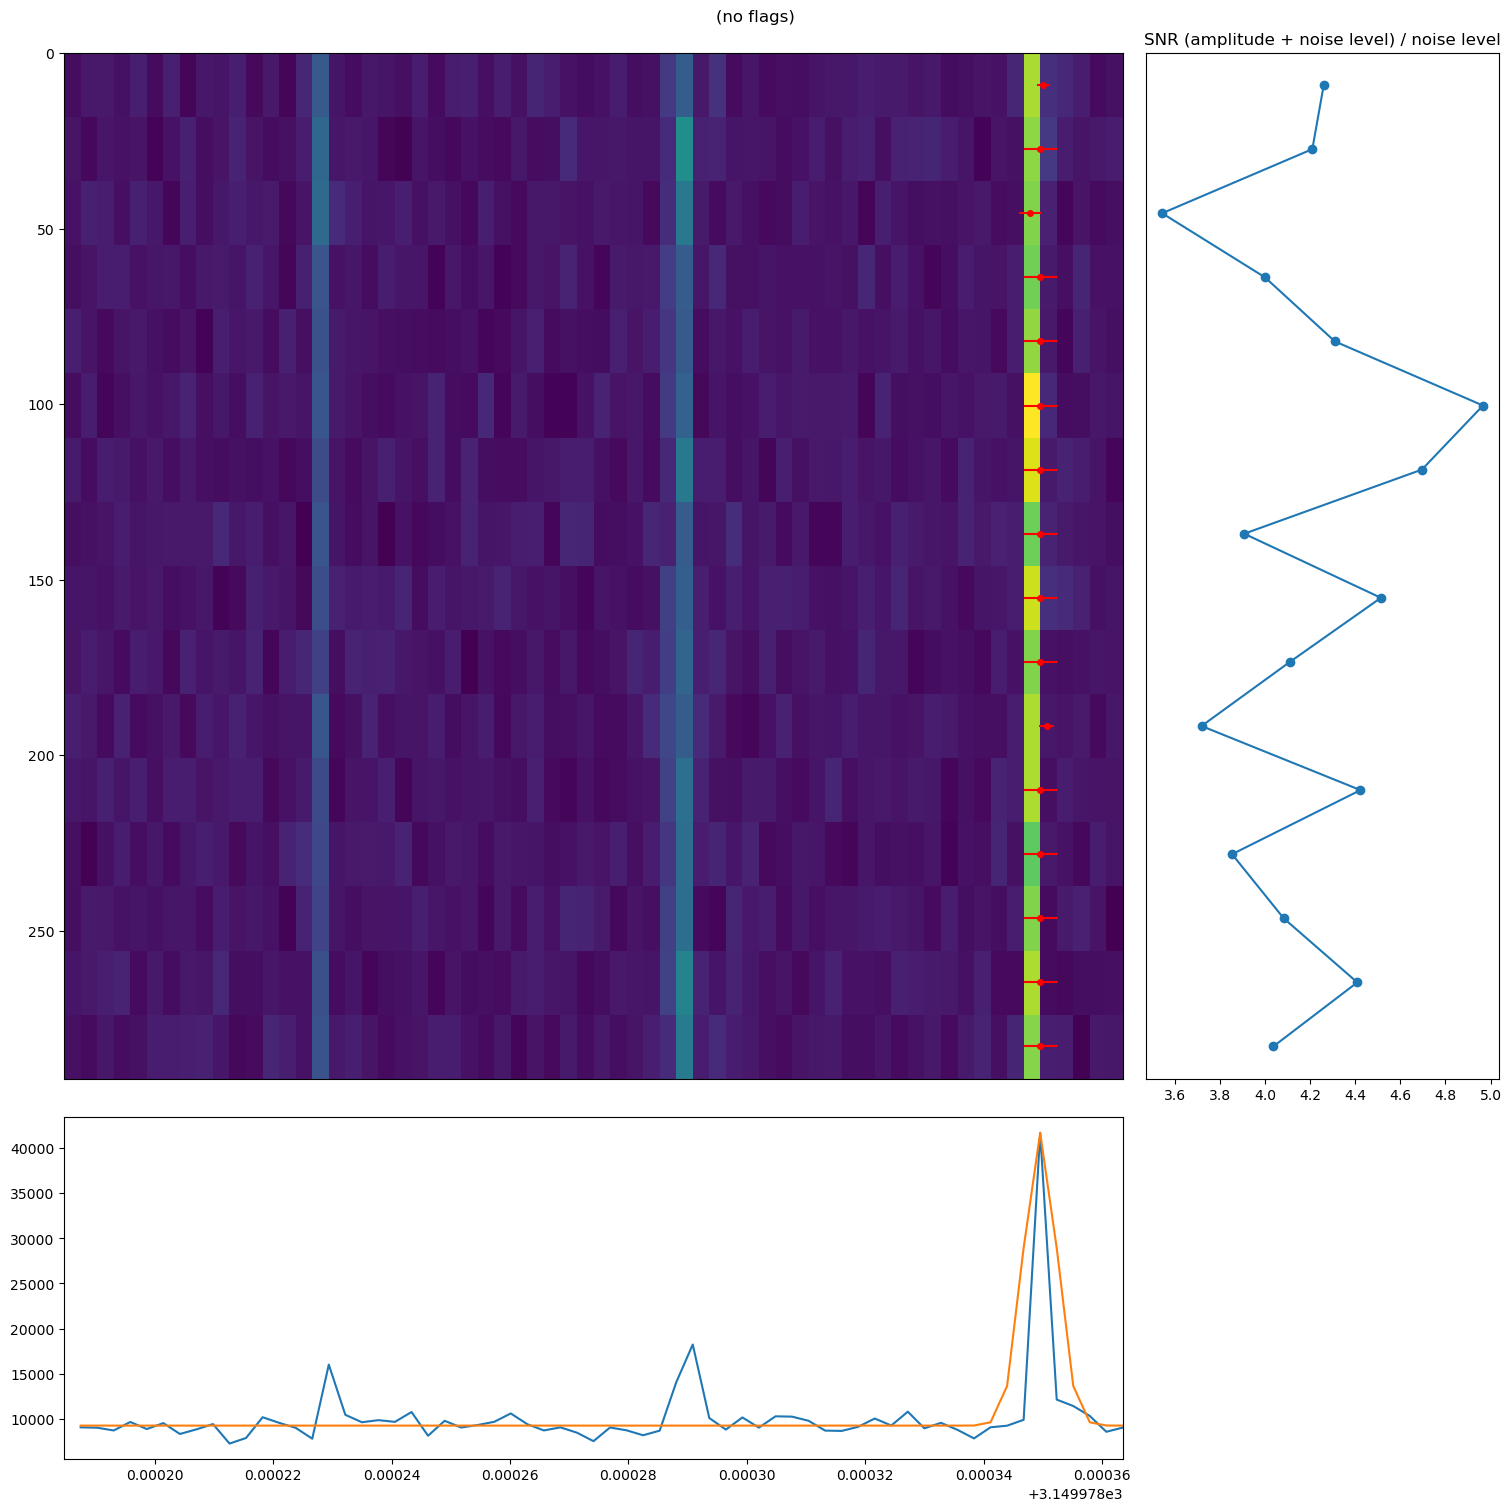

In [62]:
def make_figure(hit, title=None):
    if title is None:
        title = hit['flags'] if not pd.isna(hit['flags']) else '(no flags)'

    SLICE_IDX = 8

    l_idx = hit['frequency_index']
    data = f['data'][:, 0, l_idx : l_idx+WINDOW_SIZE]
    zap_dc(data, l_idx)
    freqs = np.linspace(
        fch1 + l_idx*foff, 
        fch1 + (l_idx + data.shape[1])*foff,
        data.shape[1],
        endpoint=False
    )
    times = (np.arange(data.shape[0]) + 0.5) * tsamp
    params, _ = fit_frequency_gaussians(freqs, data)

    fig = plt.figure(figsize=(15, 15), constrained_layout=True)
    gs = matplotlib.gridspec.GridSpec(2, 2, figure=fig, width_ratios=[3, 1], height_ratios=[3, 1])

    im_ax = fig.add_subplot(gs[0, 0])
    snr_ax = fig.add_subplot(gs[0, 1], sharey=im_ax)
    slice_ax = fig.add_subplot(gs[1, 0], sharex=im_ax)

    # SNR calculation and plot
    snr = (params[:, 2] + params[:, 3]) / params[:, 3]
    snr_ax.plot(snr, times, marker='o')
    snr_ax.set_title('SNR (amplitude + noise level) / noise level')
    snr_ax.yaxis.set_visible(False)  # Hide y-axis on SNR plot

    im_ax.imshow(
        data,
        extent=(
            fch1 + foff*l_idx, fch1 + foff*(l_idx + data.shape[1]),
            data.shape[0] * tsamp, 0
        ),
        aspect='auto'
    )
    im_ax.errorbar(params[:, 0], times, color='red', markersize=4, xerr=params[:, 1], fmt='o')
    im_ax.invert_xaxis()
    im_ax.xaxis.set_visible(False)  # Hide x-axis on main plot

    slice_ax.plot(freqs, data[SLICE_IDX, :])
    slice_ax.plot(freqs, signal_model(freqs, *params[SLICE_IDX]))

    fig.suptitle(title)
    return fig
hit = df.sample().iloc[0]
make_figure(hit)
plt.show()

In [63]:
def save_hit_fig(hit, title=None, filename='image.png'):
    fig = make_figure(hit, title)
    fig.savefig(filename, transparent=False)

    plt.close(fig)

In [67]:
!rm scratch_images/*

In [68]:
for i, (idx, normal_hit) in enumerate(df[df['flags'].isna()].sample(25).iterrows()):
    save_hit_fig(normal_hit, title=f'normal {idx}', filename=f'scratch_images/normal_{i:>02}.png')

In [69]:
blip_df = df[df['flags'].str.contains('blip', na=False)]
for i, (idx, blip_hit) in enumerate(blip_df.iterrows()):
    save_hit_fig(blip_hit, title=f'blip {idx}, {blip_hit['flags']}', filename=f'scratch_images/blip_{i:>03}.png')

In [70]:
bright_df = df[df['snr'] > 10]
for i, (idx, bright_hit) in enumerate(bright_df.sample(25).iterrows()):
    save_hit_fig(bright_hit, title=f'bright {idx}, snr={bright_hit['snr']}, {blip_hit['flags']}', filename=f'scratch_images/bright_{i:>03}.png')